In [76]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [77]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [793]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

In [79]:
import requests
import json
from datetime import datetime
import time

In [80]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

### Import Custom Modules

In [672]:
from config import yelp_api_key
from config import darksky_api_key
from restaurant_info import Location
from weather import Weather

## Set Up

In [673]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-10' # End Date Exclusive

search_business = 'The Counting Room' # Not the actual Restaurant 
location = 'Brooklyn, NY'

## Pull Weather Data

### Get Latitude & Longitude from Yelp API

In [674]:
rest_loc = Location(search_business, location)
lat, long = rest_loc.get_lat_long()

Weather Location: The Counting Room


### Darksky API Call

In [678]:
weather_call = Weather(lat, long,'19:30:00')
weather_df = weather_call.weather_df(start_date, end_date)

In [679]:
weather_df.to_csv(f'csv/weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'csv/weather_{start_date}_to_{end_date}.csv'

## Import / Clean / Prep File

In [1265]:
# Restaurant File
current_file = 'csv/rest_1_daily_sales.csv'

# Weather File
weather_csv_file = 'csv/weather_2017-01-01_to_2019-06-10.csv'

In [1266]:
class importMerge:
    
    def __init__(self, sales_file, weather_file, start_date, end_date):
        
        self.sales_file = sales_file
        self.weather_file = weather_file
        self.start_date = start_date
        self.end_date = end_date
    
    def import_clean_merge(self):
        
        data = pd.read_csv(self.sales_file, index_col = 'date', parse_dates=True)
        df = pd.DataFrame(data)

        # Rename Column to 'sales'
        df = df.rename(columns={'net_sales': 'sales'})

        # Fill NaN
        df.fillna(0, inplace=True)

        # Filter to target dates
        df = df[(df.index > self.start_date) & (df.index < self.end_date)]

        # Import and clean weather file
        weather_df_csv = pd.read_csv(self.weather_file, parse_dates=True, index_col='date')
        weather_df_csv['summary'].fillna(value='none', inplace=True)

        # Merge sales and weather csv
        df = pd.merge(df, weather_df_csv, how='left', on='date')
        
        return df

### Encode Closed Days

In [1489]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 

In [1773]:
class CalendarTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, additional_closed_dates):
        self.additional_closed_dates = additional_closed_dates
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        cal = calendar()
        
        potential_closed_dates = X[X[target] == 0].index
        
        X['closed'] = np.where((((X.index.isin(potential_closed_dates)) & \
                              (X.index.isin(cal.holidays(start_date, end_date)))) | X.index.isin(self.additional_closed_dates)), 1, 0)
        
        X['sales'] = np.where(X['closed'] == 1, 0, X['sales'])
        
        # THREE DAY WEEKEND FEATURE
        sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
        X['sunday_three_day'] = np.where(X.index.isin(sunday_three_days), 1, 0)
        
        return X

In [1774]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, z_thresh, cols = ['sales', 'covers']):
        self.z_thresh = z_thresh
        self.cols = cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        for c in self.cols:
            
            count = 0
            
            for d in X['day_of_week'].unique():
                
                # Median / Mean / STD for each day of the week
                daily_median = np.median(X[X['day_of_week'] == d][c])
                daily_mean = np.mean(X[X['day_of_week'] == d][c])
                daily_std = np.std(X[X['day_of_week'] == d ][c])

                # Temporary column encoded if Target Columns have an Outlier
                X['temp_col'] = np.where((X['day_of_week'] == d) & (X['closed'] == 0) & ((np.abs(X[c] - daily_mean)) > (daily_std * self.z_thresh)), 1, 0)

                # Replace Outlier with Median
                count += np.sum(X['temp_col'])
                X[c] = np.where(X['temp_col'] == 1, daily_median, X[c])
                X.drop(['temp_col'], axis=1, inplace=True)
                
            print(f'Outliers imputed - {c}: {count} -> {(count / len(df)*100):.2f}% of total')
            
        return X

In [1776]:
class BasicFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, month_clusters):
        self.mo_k = month_clusters
        
    def fit(self, X, y = None):
        return self
           
    def transform(self, X, y = None):
        
        """Per Person Average"""
        
        X['ppa'] = np.where(X['covers'] > 0, X['sales'] / X['covers'], 0)
        
        
        """ KMeans Month Clusters"""
        
        # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
        describe = X.groupby('month')[target].aggregate(['median', 'std', 'max'])
        temp_df = describe.reset_index()

        # SCALE TEMPORARY DF
        scaler = MinMaxScaler()
        f = scaler.fit_transform(temp_df)

        # INSTANTIATE MODEL
        km = KMeans(n_clusters=self.mo_k, random_state=0).fit(f)

        # GET KMEANS CLUSTER PREDICTIONS
        labels = km.predict(f)

        # MAKE SERIES FROM PREDICTIONS
        temp_series = pd.DataFrame(labels, columns = ['cluster'], index=temp_df.index)

        # CONCAT CLUSTERS TO DATAFRAME
        temp_df = pd.concat([temp_df, temp_series], axis=1)

        # CREATE CLUSTER DICTIONARY
        temp_dict = {}
        for i in list(X['month']):
            
            temp_dict[i] = temp_df.loc[temp_df['month'] == i, 'cluster'].iloc[0]
        
        X['month_cluster'] = X['month'].apply(lambda x: temp_dict[x]).astype('category')
        X.drop(['month'], axis=1, inplace=True)
        
        
        """Day & Month Cluster Dummies"""
        
        X['day_of_week'] = X['day_of_week'].astype('category')
        X = pd.get_dummies(data=X, columns=['day_of_week', 'month_cluster'])
        
        
        """ Trend Engineering """
        
        X['target_trend'] = X[target].shift(1).rolling(trend_days_rolling).mean() / \
                            X[target].shift(1 + trend_days_shift).rolling(trend_days_rolling).mean()
        
        return X

In [1815]:
class WeatherFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, temp_bins, open_time, close_time):
        self.temp_bins = temp_bins
        self.open_time = open_time
        self.close_time = close_time
    
    def fit(self, X, y = None):
        return self
    
    def between_time(self, check_time):

        hs_dt = datetime.strptime(self.open_time, "%I:%M%p")
        he_dt = datetime.strptime(self.close_time, "%I:%M%p")

        if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:
            return 1
        else:
            return 0
    
    def transform(self, X, y = None):
    
        """ Bin & Encode Temperature """
        
        #Onehot encoder
        temp_enc = KBinsDiscretizer(n_bins=self.temp_bins, encode='onehot', strategy='kmeans')
        temp_enc.fit(X[['apparent_temperature']])
    
        #Bin temps into categories
        binned_transform = temp_enc.transform(X[['apparent_temperature']])
        binned_df = pd.DataFrame(binned_transform.toarray(), index=X.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot'])
        X = X.merge(binned_df, how='left', on='date')
        
        # POOR WEATHER FEATURES
        X['precip_while_open'] = np.where(X['precip_intensity_max'] > 0, X['precip_max_time'].apply(lambda x: self.between_time(x)), 0)
        X.drop(['apparent_temperature', 'temperature', 'precip_intensity_max', 'precip_max_time', 'summary', 'precip_type'], axis=1, inplace=True)

        return X

In [1846]:
class InteractionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X['outside_X_precip_open'] = X['outside'] * X['precip_while_open']
            
        for t in [col for col in X.columns if col.startswith('temp_')]:

            col_name = t + '_X_' + 'outside'
            X[col_name] = X[t] * X['outside']

        X.drop(['outside', 'day_of_week_0'], axis=1, inplace=True)
        
        target_list = ['sales', 'covers', 'ppa']
    
        if X.columns.any() in target_list:
        
            target_to_drop = [t for t in target_list if t != target]
            X.drop(target_to_drop, axis=1, inplace=True)
            
        return X


In [1847]:
target_list = ['sales', 'ppa', 'covers']
target = 'sales'

temp_bins = 4
month_clusters = 4

open_time = '05:00PM'
close_time = '11:59PM'

trend_days_rolling = 28
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

In [1848]:
pipeline = Pipeline ( steps = [ ( 'closed' , CalendarTransformer(additional_closed_dates) ),
                                ( 'outliers', OutlierTransformer(z_thresh) ),
                                ( 'basic_features', BasicFeatureTransformer(month_clusters) ),
                                ( 'weather_features', WeatherFeatureTransformer(temp_bins, open_time, close_time) ),
                                ( 'interactions', InteractionTransformer() ) ] )

In [1849]:
obj = importMerge(current_file, weather_csv_file, start_date, end_date)
hello = obj.import_clean_merge()

In [1850]:
hello = pipeline.fit_transform(hello)

Outliers imputed - sales: 13 -> 1.46% of total
Outliers imputed - covers: 11 -> 1.24% of total


In [1851]:
hello.tail()

,sales,humidity,precip_prob,pressure,closed,sunday_three_day,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,temp_very_cold,temp_cold,temp_warm,temp_hot,precip_while_open,outside_X_precip_open,temp_very_cold_X_outside,temp_cold_X_outside,temp_warm_X_outside,temp_hot_X_outside
date,,,,,,,,,,,,,,,,,,,,,
2019-06-05,15613.58,0.71,0.0,1007.12,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0
2019-06-06,18421.26,0.50,0.0,1008.61,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0
2019-06-07,21023.88,0.77,0.0,1014.18,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,1,1,0.0,0.0,0.0,1.0
2019-06-08,21201.51,0.40,0.0,1022.45,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0
2019-06-09,20616.10,0.37,0.0,1025.03,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0


In [1852]:
# Set Closed Dates using Sales & User Input

# CLOSED DATES
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-01-01', '2018-02-04', '2019-02-03']
closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]

# Drop or Encode Closed Days
def encode_closed_days(df):

    # CLOSED FEATURE
    cal = calendar()

    # Local list of days with zero sales
    potential_closed_dates = df[df['sales'] == 0].index

    # Enocodes closed days with 1
    df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                              (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    df['sales'] = np.where(df['closed'] == 1, 0, df['sales'])
    
    return df

### Impute Outliers in Data

In [1269]:
 #Replace Outliers with Medians
## Targets for Outliers

z_thresh = 2

def impute_outliers(df, *col):
    
    # Check for Outliers in Sales + Covers
    for c in col:
        
        count = 0
        
        # Impute Median for Sales & Covers Based on Day of Week Outiers
        for d in df['day_of_week'].unique():
            
            # Median / Mean / STD for each day of the week
            daily_median = np.median(df[df['day_of_week'] == d][c])
            daily_mean = np.mean(df[df['day_of_week'] == d][c])
            daily_std = np.std(df[df['day_of_week'] == d ][c])
            
            # Temporary column encoded if Target Columns have an Outlier
            df['temp_col'] = np.where((df['day_of_week'] == d) & (df['closed'] == 0) & ((np.abs(df[c] - daily_mean)) > (daily_std * z_thresh)), 1, 0)
            
            # Replace Outlier with Median
            count += np.sum(df['temp_col'])
            df[c] = np.where(df['temp_col'] == 1, daily_median, df[c])
            df = df.drop(['temp_col'], axis=1)

        print(f'Outliers imputed - {c}: {count} -> {(count / len(df)*100):.2f}% of total')
    
    return df

### Add Per Person Average (PPA)

In [1270]:
# Add column with Per Person Average (Sales per Cover)
def add_ppa(df):
    
    df['ppa'] = np.where(df['covers'] > 0, df['sales'] / df['covers'], 0)
    
    return df

## Clean File Here

In [1271]:
data = add_ppa(impute_outliers(encode_closed_days(data), 'sales', 'covers'))

Outliers imputed - sales: 13 -> 1.46% of total
Outliers imputed - covers: 11 -> 1.24% of total


### Export CSV for EDA

In [1272]:
data.to_csv('csv/CSV_for_EDA.csv')

## CHOOSE TARGET --> SALES OR COVERS

### Create Month Clusters

In [1274]:
day_k = 7
mo_k = 4

def create_clusters(df, target, col, k):
    
    # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
    describe = df.groupby(col)[target].aggregate(['median', 'std', 'max'])
    df = describe.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

# Create Global Dictionaries to Categorize Day / Month
#day_dict = create_clusters(data, 'day_of_week', day_k)
month_dict = create_clusters(data, target, 'month', mo_k)

In [1275]:
# Print Clusters
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Month Clusters:  {1: 2, 2: 3, 3: 2, 4: 3, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  4


### Add Temperature Onehot Categories

In [1276]:
def encode_temp(df):
    
    #Onehot encoder
    temp_enc = KBinsDiscretizer(n_bins=4, encode='onehot', strategy='kmeans')
    temp_enc.fit(df[['apparent_temperature']])
    
    return temp_enc
    
def one_hot_temp(df, temp_enc):
    
    #Bin temps into five categories
    binned_transform = temp_enc.transform(df[['apparent_temperature']])
    binned_df = pd.DataFrame(binned_transform.toarray(), index=df.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot'])
    df = df.merge(binned_df, how='left', on='date')
    df.drop(['apparent_temperature', 'temperature'], axis=1, inplace=True)

    return df, temp_enc

## Feature Engineering

In [1277]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    #df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x]).astype('category')
    df['month_cluster'] = df['month'].apply(lambda x: month_dict[x]).astype('category')
    df = df.drop(['month'], axis=1)
    
    return df

### Add Weather Features

In [1278]:
hours_start = '05:00PM'
hours_end = '11:59PM'

hs_dt = datetime.strptime(hours_start, "%I:%M%p")
he_dt = datetime.strptime(hours_end, "%I:%M%p")

def between_time(check_time):
        
    if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:

        return 1

    else:

        return 0

In [1279]:
add_weather = True

def add_weather_features(df):
    
    if add_weather:
        
        # POOR WEATHER FEATURES
        df['precip_while_open'] = np.where(df['precip_intensity_max'] > 0, df['precip_max_time'].apply(lambda x: between_time(x)), 0)
    
        # DROP FEATURES
        features_to_drop = ['precip_max_time']
        df.drop(features_to_drop, axis=1, inplace=True)
        
    return df

### Add Calendar Features

In [1280]:
def add_cal_features(df):
    
    cal = calendar()

    # THREE DAY WEEKEND FEATURE
    sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)
    
    return df

### Add Dummies

In [1281]:
def add_dummies(df):
    
    df['day_of_week'] = df['day_of_week'].astype('category')
    
    df = pd.get_dummies(data=df, columns=['day_of_week', 'month_cluster'])
    
    return df

### Add Interactions

In [1282]:
def add_interactions(df):
    
    apply_this_interaction = False
    
    if apply_this_interaction:
        
        for d in [col for col in df.columns if col.startswith('day_of_week')]:
            
            for m in [col for col in df.columns if col.startswith('month_cluster')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('month_cluster')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df

In [1283]:
def add_weather_interactions(df):
    
    apply_this_interaction = True
    
    if apply_this_interaction:
        
        try:
            
            df['outside_X_precip_open'] = df['outside'] * df['precip_while_open']
            
            for t in [col for col in df.columns if col.startswith('temp_')]:

                col_name = t + '_X_' + 'outside'
                df[col_name] = df[t] * df['outside']

            df.drop(['outside'], axis=1, inplace=True)
            
        except:
            
            pass
        
        return df
    
    else:
        
        return df

### Feature Selection

In [1451]:
def feature_selection(df):
    
    target_list = ['sales', 'covers', 'ppa']
    
    if df.columns.any() in target_list:
        
        target_to_drop = [t for t in target_list if t != target]
        df = df.drop(target_to_drop, axis=1)
        
    else:
        pass
        
    # Feature Selection / Drop unnecessary or correlated columns
    cols_to_drop = ['precip_type', 'summary', 'pressure', 'precip_intensity_max', 'day_of_week_0']
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

### Add Target Trend Feature Engineering

In [1452]:
trend_days_rolling = 28
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

def target_trend_engineering(df):
    
    df['target_trend'] = df[target].shift(1).rolling(trend_days_rolling).mean() / df[target].shift(1 + trend_days_shift).rolling(trend_days_rolling).mean()
    
    return df

## Start Here

In [1766]:
# IMPORT & PARSE CLEAN TRAINING SET
obj = importMerge(current_file, weather_csv_file, start_date, end_date)
data = obj.import_clean_merge()

dfx = impute_outliers(encode_closed_days(data), 'sales', 'covers');

Outliers imputed - sales: 13 -> 1.46% of total
Outliers imputed - covers: 11 -> 1.24% of total


In [1768]:
dfx.sales.sum()

14472540.75

In [1769]:
# One Hot Encode Temperature Data
dfx, temp_enc = one_hot_temp(dfx, encode_temp(dfx))

In [1770]:
dfx = (dfx.pipe(add_ppa)
    .pipe(add_clusters)
    .pipe(add_weather_features)
    .pipe(add_cal_features)
    .pipe(add_dummies)
    .pipe(add_interactions)
    .pipe(add_weather_interactions)
    .pipe(feature_selection)
    .pipe(target_trend_engineering))


In [1771]:
dfx.precip_while_open.sum()

132

In [1431]:
# def feature_engineering(df):
    
#     df = add_ppa(df)
    
#     # Add day & Month Clusters // Dicts with data held in Global Variable
#     df = add_clusters(df)
    
#     # Add Engineered Features for Weather & Calendar
#     df = add_weather_features(df)
#     df = add_cal_features(df)
    
#     # Create Dummies
#     df = add_dummies(df)
    
#     # Add Interactions
#     df = add_interactions(df)
#     df = add_weather_interactions(df)
    
#     # Drop Selected Columns
#     df = feature_selection(df)
    
#     df = target_trend_engineering(df)
    
#     return df

# dfx = feature_engineering(dfx)

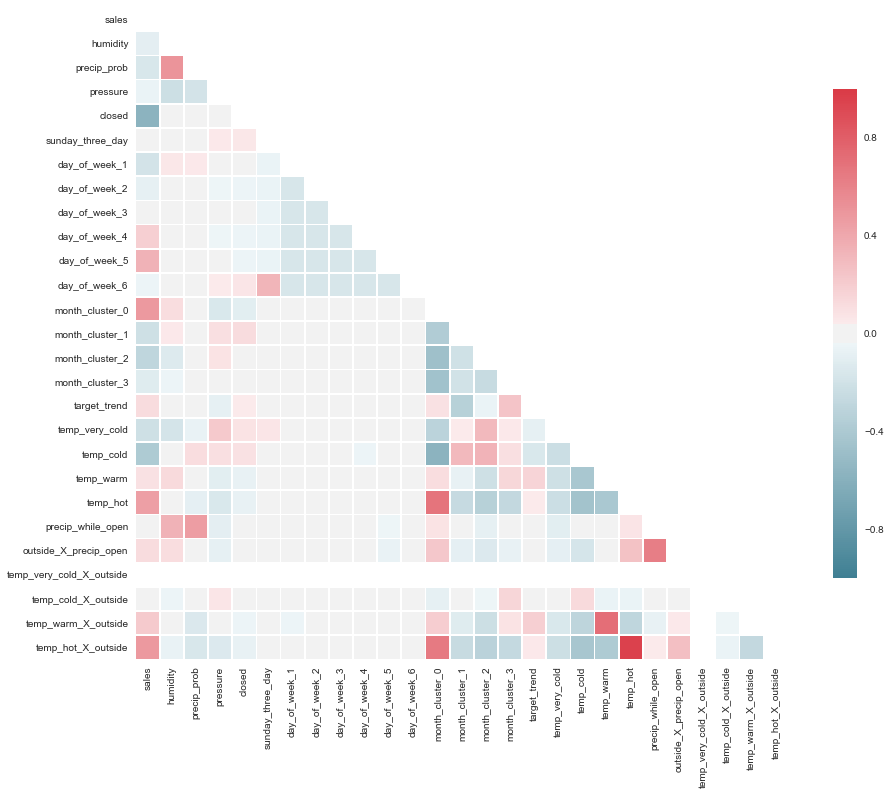

In [1859]:
def corr_chart(df):
    
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
corr_chart(hello)

## Train / Test / Split

In [1853]:
def cv_split(df):
    
    features = dfx.drop([target], axis=1)[days_fwd:]
    y = dfx[target][days_fwd:]
    
    return features, y

cv_features, cv_y = cv_split(hello)

In [1854]:
def train_test_split(df):
    
    # Separate Target & Features
    y = df[target]
    features = df.drop([target], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    X_train = pd.DataFrame(X_train, columns=X_train.columns)
    X_test = pd.DataFrame(X_test, columns=X_train.columns)
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = train_test_split(hello)

Train set:  694
Test set:  160


## Linear Regression with Lasso Regularization

In [1855]:
# Linear Regression - Lasso Model Set Up
def lasso_model(X_train, y_train):

    lassoReg = Lasso(fit_intercept=True, alpha=.025)
    lasso_rgr = lassoReg.fit(X_train,y_train)

    return lasso_rgr

In [1856]:
# Run Model on Training Data
lasso_rgr = lasso_model(X_train, y_train)

In [1857]:
def rgr_score(rgr, X_train, y_train, X_test, y_test, cv_features, cv_y):
    
    y_hat = rgr.predict(X_test)
    sum_squares_residual = sum((y_test - y_hat)**2)
    sum_squares_total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(sum_squares_residual))/sum_squares_total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Formula Scores:', '\n', 'Test R-Squared: ', r_squared,'\n', 'Test Adjusted R-Squared: ', adjusted_r_squared, '\n')
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: target})
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=5, scoring='r2')), '\n')
    
    print('Intercept:  ', rgr.intercept_, '\n')
    print('Coefficients:  \n')
    
    for index, col_name in enumerate(X_test.columns):
        print(col_name, ' --> ', rgr.coef_[index])
        
    return pred_df

In [1858]:
pred_df_rgr = rgr_score(lasso_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

Formula Scores: 
 Test R-Squared:  0.8308684505446343 
 Test Adjusted R-Squared:  0.7978051401247884 

Train R-Squared:   0.7988621464027542
Test R-Squared:   0.8308684505446344 

Root Mean Squared Error:  1265.3362943848554 

Cross Val Avg R-Squared:  0.7594564515730523 

Intercept:   -3063.9213305592275 

Coefficients:  

humidity  -->  -1628.1033005100655
precip_prob  -->  -109.7410012052929
pressure  -->  9.611548614683539
closed  -->  -14432.886549992932
sunday_three_day  -->  1417.2495775624927
day_of_week_1  -->  -27.330411497129834
day_of_week_2  -->  480.5878255665503
day_of_week_3  -->  1140.1668880413843
day_of_week_4  -->  2622.5362933856727
day_of_week_5  -->  3744.3567987337597
day_of_week_6  -->  1081.6285526974389
month_cluster_0  -->  735.6867542835317
month_cluster_1  -->  395.91087857752825
month_cluster_2  -->  -327.79029945653485
month_cluster_3  -->  -45.706733707045004
target_trend  -->  7524.422587028093
temp_very_cold  -->  88.12797244339549
temp_cold  -->  318

## XGB Regressor

In [661]:
params = {
          'learning_rate': [0.015, 0.020, 0.025],
          'max_depth': [3, 4, 5],
          'min_impurity_decrease': [0.0001, 0.0025, 0.005],
          'colsample_bytree': [0.75, 0.85, 0.95],
          'n_estimators': [250, 275, 300],
          'min_child_weight': [1, 2]
        }

# Grid Search Helper Function
def xgb_grid_model(params, X_train, y_train):
    
    objective = 'reg:linear'
    booster = 'gbtree'
    
    rgr = XGBRegressor(booster=booster, objective=objective, random_state = 0)
    
    cv = 5
    n_jobs = -1
    scoring = 'neg_mean_squared_error'
    
    grid = GridSearchCV(rgr, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=5)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    xgb_rgr = best_grid_rgr.fit(X_train, y_train)
    
    return best_grid_rgr

In [662]:
best_grid_rgr = xgb_grid_model(params, X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  8.3min finished


Grid Search:  XGBRegressor 

Grid Search Best Score:  -2656713.758384412
Grid Search Best Params:  {'colsample_bytree': 0.95, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 2, 'min_impurity_decrease': 0.0001, 'n_estimators': 275}
Grid Search Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=0, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=3,
       min_child_weight=2, min_impurity_decrease=0.0001, missing=None,
       n_estimators=275, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [663]:
def tree_score(rgr, X_test, y_test, cv_features, cv_y):
    
    y_hat = rgr.predict(X_test)
    sum_squares_residual = sum((y_test - y_hat)**2)
    sum_squares_total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(sum_squares_residual))/sum_squares_total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Formula Scores:', '\n', 'Test R-Squared: ', r_squared,'\n', 'Test Adjusted R-Squared: ', adjusted_r_squared, '\n')
    
    print('Sklearn Metric Scores:')
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: 'pred_'+target})
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=5, scoring='r2')), '\n')
        
    return pred_df

pred_df = tree_score(best_grid_rgr, X_test, y_test, cv_features, cv_y) 

Formula Scores: 
 Test R-Squared:  0.8423852047758524 
 Test Adjusted R-Squared:  0.8129794593982129 

Sklearn Metric Scores:
Train R-Squared:   0.8322070245560084
Test R-Squared:   0.8423852047758524 

Root Mean Squared Error:  1221.4962628661651 

Cross Val Avg R-Squared:  0.7643099620071109 



### RESIDUAL PLOT

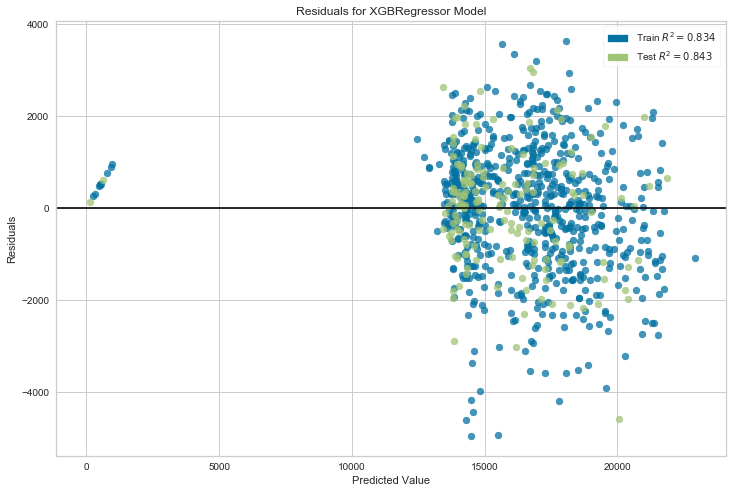

In [664]:
plt.figure(figsize=(12,8))

visualizer = ResidualsPlot(xgb_rgr, hist=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Checking Residuals

In [1467]:
res_df = pd.concat([pred_df, y_test], axis=1)
res_df['diff'] = res_df.pred_sales - res_df.sales
res_df[np.abs(res_df['diff']) > 2000]

,pred_sales,sales,diff
date,,,
2019-01-08,13417.199219,10811.32,2605.879219
2019-02-04,14220.367188,11976.75,2243.617188
2019-02-08,16915.363281,14796.74,2118.623281
2019-03-13,13874.749023,16744.55,-2869.800977
2019-04-06,17555.578125,19636.70,-2081.121875
2019-04-14,16276.001953,19197.14,-2921.138047
2019-04-18,16538.603516,18789.73,-2251.126484
2019-05-08,16816.607422,13849.69,2966.917422
2019-05-12,14882.189453,12262.59,2619.599453


### Feature Importance

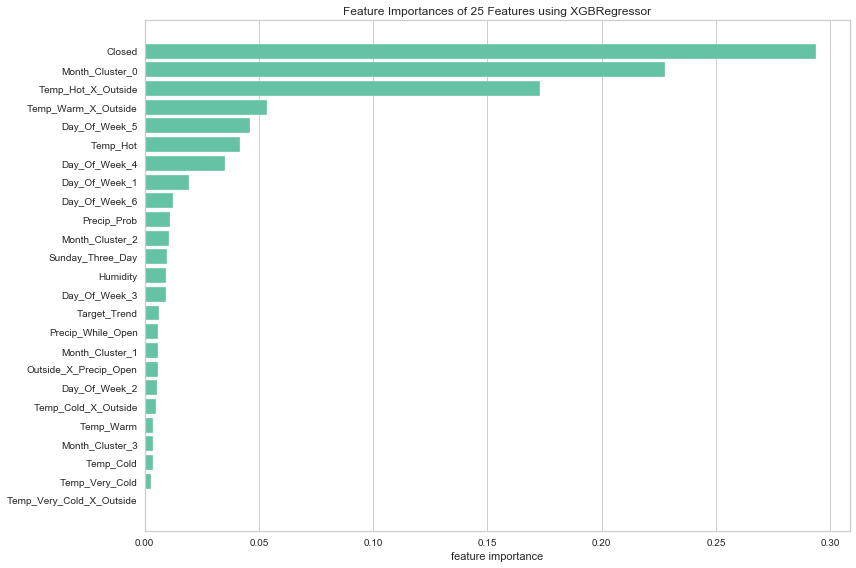

In [643]:
features = list(X_train.columns)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

labels = list(map(lambda x: x.title(), features))
visualizer = FeatureImportances(xgb_rgr, ax=ax, labels=labels, relative=False)

visualizer.fit(X_train, y_train)
visualizer.poof();

### Run Final Model on Entire Dataset

In [409]:
# Run Model on All Data
xgb_rgr_finalized = xgb_model(cv_features, cv_y)

In [220]:
# Score Finalized Model on Entire Dataset
pred_all = tree_score(xgb_rgr_finalized, cv_features, cv_y, cv_features, cv_y)

Formula Scores: 
 Test R-Squared:  0.8592607274806568 
 Test Adjusted R-Squared:  0.8548784267794558 

Sklearn Metric Scores:
Train R-Squared:   0.8511926118803055
Test R-Squared:   0.8592607274806568 

Root Mean Squared Error:  1268.816520214201 

Cross Val Avg R-Squared:  0.7404323741292844 



## Evaluation - Actual Sales vs. Predicted (On Test Set)

In [221]:
eval_df = pred_df.merge(data, on='date', how='inner')

In [222]:
eval_df['absolute_error%'] = np.where(eval_df['sales'] > 0, np.abs(eval_df['sales'] - eval_df['pred_sales']) / eval_df['sales'], 0)
eval_df['absolute_error'] = np.abs(eval_df['sales'] - eval_df['pred_sales'])
eval_df['squared_error'] = ((eval_df['sales'] - eval_df['pred_sales'])**2)

eval_df.groupby('day_of_week')['absolute_error'].describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
0,24.0,941.439290,650.865260,16.013672,452.930176,764.629375,1450.209473,2116.075781
1,25.0,887.631829,875.796160,45.201992,289.531719,486.794258,1340.586953,3168.585781
2,24.0,1279.948621,985.795601,72.950156,579.840850,933.702480,1934.534902,3638.452578
3,24.0,677.832498,654.544333,13.209883,296.457510,494.131563,789.974854,2605.995352
4,24.0,1032.701364,834.724620,105.086680,485.986631,795.715820,1405.455342,3844.305625
5,24.0,1077.353691,781.869805,15.421094,538.277441,889.433867,1452.970469,3173.118750
6,24.0,940.788504,983.549372,18.710000,186.802178,499.007988,1763.891191,2994.484141


In [223]:
eval_df['absolute_error'].sum() / len(eval_df['absolute_error'])

976.2859822759682

In [224]:
eval_df['absolute_error%'].mean()

0.06068482090177032

## Predictions

In [1487]:
outside = 0

def predict_one(rgr, current_df, end_date):
    
    date_1 = pd.to_datetime(end_date) + pd.DateOffset(-days_fwd)
    date_2 = end_date
     
    # Pull Weather Data / Forecast
    weather_df = rest_weather.weather_df(date_1, date_2)
    weather_df['outside'] = outside
    
    # One Hot Encode Temperature Using Fitted Encoder
    df, _ = one_hot_temp(weather_df, temp_enc)
    
    df['closed'] = 0

    # Add Sales Data for Sales Trend Engineering
    current_df = current_df[target]
    df = pd.merge(df, current_df, on='date', how='left')
     
    # Add Feature Engineering
    df = (df.pipe(add_clusters)
    .pipe(add_weather_features)
    .pipe(add_cal_features)
    .pipe(add_dummies)
    .pipe(add_interactions)
    .pipe(add_weather_interactions)
    .pipe(feature_selection)
    .pipe(target_trend_engineering))
    
    #df = target_trend_engineering(df)
    df = df.drop([target], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns][-1:]
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(rgr.predict(df), index=df.index, columns=[target])
    pred_df = pred_array.merge(df, on='date', how='left')
    
    return pred_df

In [1488]:
predict_date = '2019-06-10'

tonight = predict_one(best_grid_rgr, dfx, predict_date)
tonight[-1:]

2019-05-05 00:00:00 2019-06-10
37


,sales,humidity,precip_prob,closed,temp_very_cold,temp_cold,temp_warm,temp_hot,precip_while_open,sunday_three_day,...,month_cluster_0,month_cluster_1,month_cluster_2,month_cluster_3,outside_X_precip_open,temp_very_cold_X_outside,temp_cold_X_outside,temp_warm_X_outside,temp_hot_X_outside,target_trend
date,,,,,,,,,,,,,,,,,,,,,
2019-06-10,14604.677734,0.98,0.0,0,0.0,0.0,1.0,0.0,0,0,...,1,0,0,0,0,0.0,0.0,0.0,0.0,1.044396


### Predict Upcoming Week

In [133]:
def predict_multiple(rgr, df, start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    temp_df = df
    
    for day in list_of_days:
        
        temp_df = pd.concat([temp_df, predict_one(rgr, temp_df, day)], axis=0)
    
    return temp_df

upcoming_df = predict_multiple(xgb_rgr_finalized, dfx, '2019-06-19', '2019-06-25')

In [134]:
upcoming_df[-7:][[target, 'closed', 'humidity', 'precip_prob', 'precip_while_open', 'outside_X_precip_open', 'target_trend']]

,sales,closed,humidity,precip_prob,precip_while_open,outside_X_precip_open,target_trend
date,,,,,,,
2019-06-19,14610.288086,0,0.95,0.00,1,0.0,0.976882
2019-06-20,14096.017578,0,0.86,0.21,0,0.0,0.977449
2019-06-21,17220.195312,0,0.49,0.01,0,0.0,0.976745
2019-06-22,18292.398438,0,0.40,0.00,1,0.0,0.974877
2019-06-23,14665.337891,0,0.37,0.00,0,0.0,0.973045
2019-06-24,14718.222656,0,0.71,0.07,1,0.0,0.958175
2019-06-25,13878.599609,0,0.68,0.01,0,0.0,0.959670


In [135]:
np.sum(upcoming_df[-7:][target])

107481.0595703125

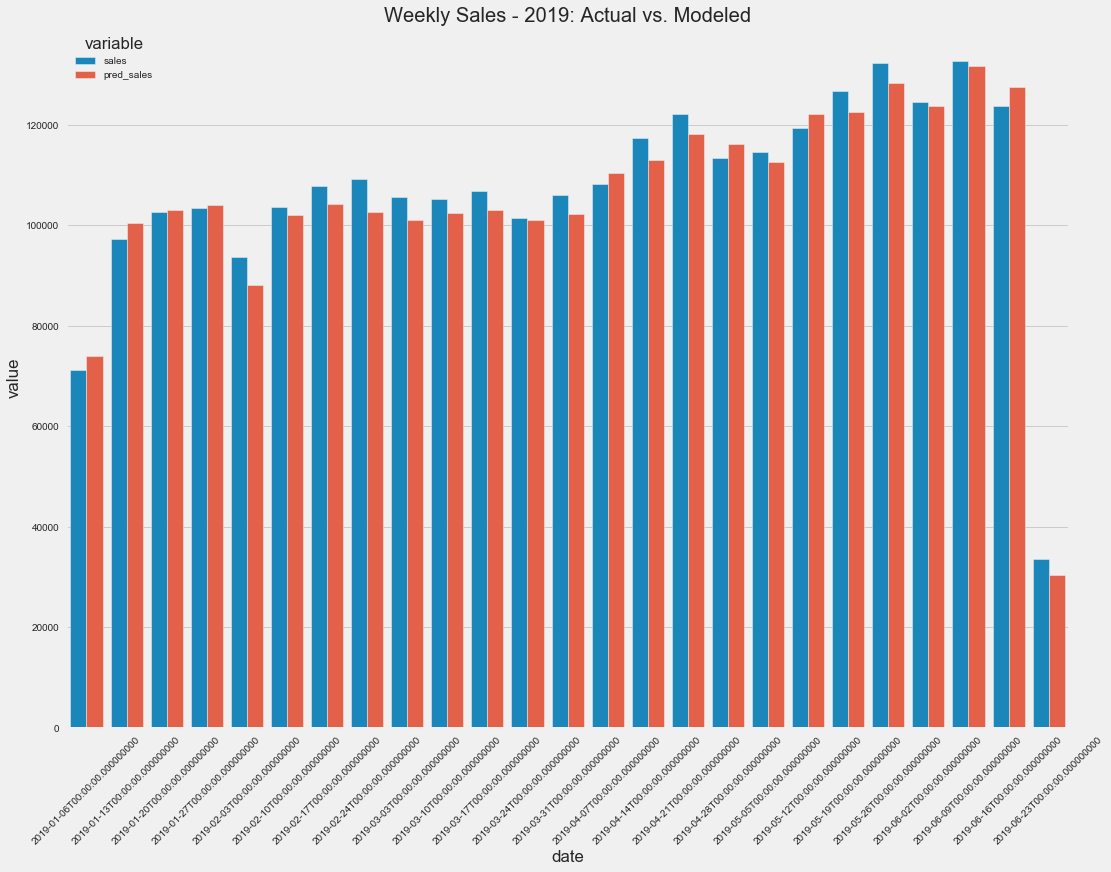

In [125]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(16,12))

eval_df_weekly = eval_df[['sales', 'pred_sales']]['2019'].resample('W').sum()
ew = pd.melt(eval_df_weekly.reset_index(), id_vars='date')

sns.barplot(x = 'date', y = 'value', hue = 'variable', data = ew)

plt.title('Weekly Sales - 2019: Actual vs. Modeled')
plt.xticks(rotation=45)

plt.show();